## Contemporary Music Recommendation System using Historical Preferences

### Overview

Many of us who are at the age when AARP cards arrive in the mail are still listening to the music of our highschool and college days. Exposure to new music has diminished due to the decreased use of the radio as part of our daily routines.  Spotify, iTunes, Pandora, and other music apps provide a plethora of music options, and they make recommendations for other music based on a playlist, but most often those recommendations are of the same time period and genre.  


#### Problem
Many of us would like to try new music, but don’t know where to start, and don’t have the patience or time to research or listen to new music as a hit or miss exercise.

#### Solution
My objective is to develop a recommendation system to highlight new songs and artists for listeners based on their  historical music preferences.

### References

I took inspiration, modeling tool suggestions, and, in some cases, actual code from the following sites.  These references are cited in the corresponding sections of this notebook. 

- **developer.spotify.com**
    - API endpoint and feature information
- **scikit-learn.org**
    - KMeans and Silhouette Score
    - Lasso regression
- **Towards Data Science**
    - Spotipy API extraction
    - K-Prototype Use Cases
- **pandas.pydata.org**
    - Changing series to an array
    - Referencing indeces
    - pd.get_dummies 

### Project Setup

#### Import Tools
In order to import, process, and build a model for song recommendations, I am importing the following tools, including those required for clustering and measuring the accuracy of recommendations: KMeans, KMode (for clustering categorical variables), PCA, Silhouette Score, and Cosine Distance 

In [1]:
import pandas as pd
import numpy as np
import io, sys, os, re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly.express as px
import requests
from itertools import chain
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import pdist

#### Import Data

This project includes obtaining the album and track audio features of songs from the 80s and 90s. These songs were found by identifying Spotify playlists representing music of different genres from this timeframe.  

##### Establish connection to Spotify's API

In [2]:
import http.client

con = http.client.HTTPConnection('https://api.spotify.com', 80, timeout=-1)

print(con)

In [3]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util


In [4]:
# The following code passes credentials in order to access the Spotify API.  Credentials are stored 
# securely in a local file

with open("API.txt", encoding="utf-8-sig") as f:
    secret_ls = f.readlines()
    cid = secret_ls[0][:-1]
    secret = secret_ls[1]
        

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

#### Create Datasets 

 - **track_data** - A list is created (track_data) to store all of the album and audio features of each track in the .txt file
 - **data** - the data from track_data is appended to another list (data).  This allows for additional data to be appended to the file if more tracks are found for training the model without having to import the entire list which is time consuming  
 

##### Lists of track dictionaries

In [5]:
# Initialize datasets (lists)
# NOTE - If adding data, do not initialize the data list.  Comment this line out to keep existing data in tact

track_data = []
data = []

In [6]:
with open("URL.txt") as g:
    for url in g:
        playlist_link = url
        playlist_URI = playlist_link.split("/")[-1].split("?")[0]
        
        for track in sp.playlist_tracks(playlist_URI)["items"]:
            #URI
            track_uri = track["track"]["uri"]
    
            #Track name
            track_name = track["track"]["name"]
    
            #Main Artist
            artist_uri = track["track"]["artists"][0]["uri"]
            artist_info = sp.artist(artist_uri)
    
            #Name, popularity, genre (the first 6 genres in alphabetical order)
            artist_name = track["track"]["artists"][0]["name"]
            artist_pop = artist_info["popularity"]
            artist_genre_1 = artist_info["genres"][0:1]
            artist_genre_2 = artist_info["genres"][1:2]
            artist_genre_3 = artist_info["genres"][2:3]
            artist_genre_4 = artist_info["genres"][3:4]
            artist_genre_5 = artist_info["genres"][4:5]
            artist_genre_6 = artist_info["genres"][5:6]
    
            #Album
            album = track["track"]["album"]["name"]
            album_date = track["track"]["album"]["release_date"]
    
            #Popularity of the track
            track_pop = track["track"]["popularity"]
    
            #Track features
            danceability = sp.audio_features(track_uri)[0]['danceability']
            acousticness = sp.audio_features(track_uri)[0]['acousticness']
            energy = sp.audio_features(track_uri)[0]['energy']
            instrumentalness = sp.audio_features(track_uri)[0]['instrumentalness']
            key = sp.audio_features(track_uri)[0]['key']
            liveness = sp.audio_features(track_uri)[0]['liveness']
            loudness = sp.audio_features(track_uri)[0]['loudness']
            mode = sp.audio_features(track_uri)[0]['mode']
            speechiness = sp.audio_features(track_uri)[0]['speechiness']
            tempo = sp.audio_features(track_uri)[0]['tempo']
            valence = sp.audio_features(track_uri)[0]['valence']
    
            #List of Dictionary and audio feature items
            track_data = [
                track_uri, 
                track_name, 
                artist_name, 
                artist_pop, 
                artist_genre_1, 
                artist_genre_2, 
                artist_genre_3,
                artist_genre_4, 
                artist_genre_5, 
                artist_genre_6, 
                album, 
                album_date, 
                danceability, 
                acousticness, 
                energy, 
                instrumentalness, 
                key, 
                liveness, 
                loudness, 
                mode, 
                speechiness, 
                tempo, 
                valence]
    
            #Append track_data to data list
            data.append(track_data)

HTTP Error for GET to https://api.spotify.com/v1/artists/5e4Dhzv426EvQe3aDb64jL with Params: {} returned 401 due to The access token expired


SpotifyException: http status: 401, code:-1 - https://api.spotify.com/v1/artists/5e4Dhzv426EvQe3aDb64jL:
 The access token expired, reason: None

In [7]:
len(data)

2857

In [ ]:
## Pull all albums for artists in playlists
sp_albums = []

for artist in data:
    #Pull all of the artist's albums
    sp_albums.append(sp.artist_albums(artist_uri, album_type='album'))
    
sp_albums

In [147]:
type(sp_albums)

dict

In [148]:
#Store artist's albums' names' and uris in separate lists
album_names = []
album_uris = []
    
for i in range(len(sp_albums['items'])):
    album_names.append(sp_albums['items'][i]['name'])
    album_uris.append(sp_albums['items'][i]['uri'])
        
    album_names
    album_uris
    
print(album_uris)
print(album_names)

['spotify:album:0yjoiwJLY6tF08MGUeIl4B', 'spotify:album:1nwepTujQw5I0vakqRnzk5', 'spotify:album:5LUstUbdQByrwRAYmRtE7T', 'spotify:album:6RoSMnF1izIig4yrxHaQIE', 'spotify:album:1sL3m0DXOpWJGteBxSWQS3', 'spotify:album:3jBXlXbedZKX9wH6g4u73H', 'spotify:album:2q4fMcxIO97iCxITHKIMmA', 'spotify:album:65KkAdagd7DwSv22zmjxJ7', 'spotify:album:7c3FMymY4UvkHkF1yV2hdO', 'spotify:album:1lc2QKgin57gZFATZIjhws', 'spotify:album:4UIJWjtTS32wT7CMP7Oyuy', 'spotify:album:6ZaV5sXXMGuGNEBEXBdbXF', 'spotify:album:4bUSEEG0wzNtYdCGJgd7fS', 'spotify:album:2lKV4ibm7fbNuU0sfGuRmK', 'spotify:album:3H7htkjBX3E1pMkxnJKKq2', 'spotify:album:0fRn0iTNp7731uPsivLkXj', 'spotify:album:0QFOvCTA4oqLxz1UJnCyGI', 'spotify:album:7bNpYL4bvBMLRyafghBrCs', 'spotify:album:4Enc1z5S8zcRxrVKcgnTyn']
['15 Classic Tracks: Sheena Easton', 'Fabulous', 'Best Ballads', 'Fabulous', 'My Cherie', 'The World Of Sheena Easton - The Singles', 'No Strings', 'What Comes Naturally (Expanded Edition)', 'The Lover In Me', 'The Lover In Me (Expanded Ed

In [149]:
len(data)
df_artists

[{'external_urls': {'spotify': 'https://open.spotify.com/artist/5gznATMVO85ZcLTkE9ULU7'},
  'href': 'https://api.spotify.com/v1/artists/5gznATMVO85ZcLTkE9ULU7',
  'id': '5gznATMVO85ZcLTkE9ULU7',
  'name': 'Lenny Kravitz',
  'type': 'artist',
  'uri': 'spotify:artist:5gznATMVO85ZcLTkE9ULU7'}]

##### Dataframes

In [47]:
# Convert dictionary (data) into pandas dataframe (df)
df = pd.DataFrame.from_dict(data)

##### Size and Shape of Dataframes

In [48]:
display(df.shape)
display(df.info)


(6394, 23)

<bound method DataFrame.info of                                         0   \
0     spotify:track:1qPbGZqppFwLwcBC1JQ6Vr   
1     spotify:track:31AOj9sFz2gM0O3hMARRBx   
2     spotify:track:57iDDD9N9tTWe75x6qhStw   
3     spotify:track:1d6KS9GH06JAd19uiBy9IE   
4     spotify:track:5DiXcVovI0FcY2s0icWWUu   
...                                    ...   
6389  spotify:track:5074Vt992hKDNhwXMhRceJ   
6390  spotify:track:2AeelxeYAriGv9fHq1Fjsg   
6391  spotify:track:7LvXGoyrWgYNywEC5s8awF   
6392  spotify:track:2O3JCRH7IvUUbzbxEvoVAi   
6393  spotify:track:5rzFkngmpxkgyNj0JlGvgB   

                                        1                  2   3   \
0                               Wonderwall              Oasis  75   
1                       Losing My Religion             R.E.M.  72   
2                    Bitter Sweet Symphony          The Verve  65   
3                   Ironic - 2015 Remaster  Alanis Morissette  67   
4                                Mr. Jones     Counting Crows  67   
.

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6394 entries, 0 to 6393
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       6394 non-null   object 
 1   1       6394 non-null   object 
 2   2       6394 non-null   object 
 3   3       6394 non-null   int64  
 4   4       6394 non-null   object 
 5   5       6394 non-null   object 
 6   6       6394 non-null   object 
 7   7       6394 non-null   object 
 8   8       6394 non-null   object 
 9   9       6394 non-null   object 
 10  10      6394 non-null   object 
 11  11      6394 non-null   object 
 12  12      6394 non-null   float64
 13  13      6394 non-null   float64
 14  14      6394 non-null   float64
 15  15      6394 non-null   float64
 16  16      6394 non-null   int64  
 17  17      6394 non-null   float64
 18  18      6394 non-null   float64
 19  19      6394 non-null   int64  
 20  20      6394 non-null   float64
 21  21      6394 non-null   float64
 22  

In [50]:
# Update column headers

df.columns = ['track_uri', 
        'track_name', 
        'artist_name', 
        'artist_pop', 
        'artist_genre_1', 
        'artist_genre_2', 
        'artist_genre_3',
        'artist_genre_4', 
        'artist_genre_5', 
        'artist_genre_6', 
        'album', 
        'album_date', 
        'danceability', 
        'acousticness', 
        'energy', 
        'instrumentalness', 
        'key', 
        'liveness', 
        'loudness', 
        'mode', 
        'speechiness', 
        'tempo', 
        'valence']

##### Remove duplicate tracks from dataframe

Audio tracks may be duplicated across playlists.  As a result, the code below will identify duplicate entries and subsequently drop them from the file

In [51]:
df.drop_duplicates(subset = ['track_uri'], inplace = True)

In [52]:
type(df)

pandas.core.frame.DataFrame

In [53]:
# Convert album date to a date format
df['album_date'] = pd.to_datetime(df['album_date'])

In [54]:
df['album_date']

0      1995-10-02
1      1991-03-12
2      1997-09-29
3      1995-01-01
4      1993-01-01
          ...    
6389   2011-09-23
6390   1989-05-02
6391   2010-04-30
6392   2015-01-18
6393   2008-08-08
Name: album_date, Length: 4624, dtype: datetime64[ns]

In [55]:
df

,track_uri,track_name,artist_name,artist_pop,artist_genre_1,artist_genre_2,artist_genre_3,artist_genre_4,artist_genre_5,artist_genre_6,...,acousticness,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,spotify:track:1qPbGZqppFwLwcBC1JQ6Vr,Wonderwall,Oasis,75,[beatlesque],[britpop],[madchester],[permanent wave],[rock],[],...,0.00236,0.854,0.000000,2,0.1330,-5.609,1,0.0366,174.584,0.456
1,spotify:track:31AOj9sFz2gM0O3hMARRBx,Losing My Religion,R.E.M.,72,[alternative rock],[athens indie],[permanent wave],[pop rock],[rock],[],...,0.17900,0.855,0.000001,9,0.0987,-5.051,0,0.0295,125.639,0.803
2,spotify:track:57iDDD9N9tTWe75x6qhStw,Bitter Sweet Symphony,The Verve,65,[alternative rock],[britpop],[permanent wave],[pop rock],[rock],[shoegaze],...,0.03350,0.917,0.000000,9,0.4060,-6.006,1,0.0479,171.176,0.518
3,spotify:track:1d6KS9GH06JAd19uiBy9IE,Ironic - 2015 Remaster,Alanis Morissette,67,[canadian pop],[canadian singer-songwriter],[pop rock],[singer-songwriter],[],[],...,0.21800,0.582,0.000000,11,0.1590,-8.305,1,0.0508,114.926,0.365
4,spotify:track:5DiXcVovI0FcY2s0icWWUu,Mr. Jones,Counting Crows,67,[alternative rock],[neo mellow],[pop rock],[rock],[],[],...,0.18300,0.817,0.000003,0,0.2850,-6.542,1,0.0363,141.621,0.726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6389,spotify:track:5074Vt992hKDNhwXMhRceJ,Touch in the Night - Radio Version,Silent Circle,44,[europop],[italian disco],[new italo disco],[spacesynth],[],[],...,0.11400,0.731,0.021700,9,0.2800,-7.592,0,0.0328,123.088,0.924
6390,spotify:track:2AeelxeYAriGv9fHq1Fjsg,Too Many Broken Hearts,Jason Donovan,47,[australian dance],[australian pop],[europop],[new wave pop],[],[],...,0.10400,0.966,0.000000,9,0.3570,-6.554,0,0.0440,122.214,0.921
6391,spotify:track:7LvXGoyrWgYNywEC5s8awF,Ussr,Eddy Huntington,31,[italian disco],[new italo disco],[],[],[],[],...,0.19600,0.814,0.011900,0,0.0348,-7.546,0,0.0316,110.457,0.972
6392,spotify:track:2O3JCRH7IvUUbzbxEvoVAi,High Energy,Evelyn Thomas,36,[disco],[diva house],[hi-nrg],[],[],[],...,0.14300,0.765,0.046100,10,0.2500,-12.772,0,0.0619,124.252,0.711


In [56]:
#  Convert list columns to string

df['artist_genre_1'] = df.artist_genre_1.apply(''.join)
df['artist_genre_2'] = df.artist_genre_2.apply(''.join)
df['artist_genre_3'] = df.artist_genre_3.apply(''.join)
df['artist_genre_4'] = df.artist_genre_4.apply(''.join)
df['artist_genre_5'] = df.artist_genre_5.apply(''.join)
df['artist_genre_6'] = df.artist_genre_6.apply(''.join)

In [57]:
df

,track_uri,track_name,artist_name,artist_pop,artist_genre_1,artist_genre_2,artist_genre_3,artist_genre_4,artist_genre_5,artist_genre_6,...,acousticness,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,spotify:track:1qPbGZqppFwLwcBC1JQ6Vr,Wonderwall,Oasis,75,beatlesque,britpop,madchester,permanent wave,rock,,...,0.00236,0.854,0.000000,2,0.1330,-5.609,1,0.0366,174.584,0.456
1,spotify:track:31AOj9sFz2gM0O3hMARRBx,Losing My Religion,R.E.M.,72,alternative rock,athens indie,permanent wave,pop rock,rock,,...,0.17900,0.855,0.000001,9,0.0987,-5.051,0,0.0295,125.639,0.803
2,spotify:track:57iDDD9N9tTWe75x6qhStw,Bitter Sweet Symphony,The Verve,65,alternative rock,britpop,permanent wave,pop rock,rock,shoegaze,...,0.03350,0.917,0.000000,9,0.4060,-6.006,1,0.0479,171.176,0.518
3,spotify:track:1d6KS9GH06JAd19uiBy9IE,Ironic - 2015 Remaster,Alanis Morissette,67,canadian pop,canadian singer-songwriter,pop rock,singer-songwriter,,,...,0.21800,0.582,0.000000,11,0.1590,-8.305,1,0.0508,114.926,0.365
4,spotify:track:5DiXcVovI0FcY2s0icWWUu,Mr. Jones,Counting Crows,67,alternative rock,neo mellow,pop rock,rock,,,...,0.18300,0.817,0.000003,0,0.2850,-6.542,1,0.0363,141.621,0.726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6389,spotify:track:5074Vt992hKDNhwXMhRceJ,Touch in the Night - Radio Version,Silent Circle,44,europop,italian disco,new italo disco,spacesynth,,,...,0.11400,0.731,0.021700,9,0.2800,-7.592,0,0.0328,123.088,0.924
6390,spotify:track:2AeelxeYAriGv9fHq1Fjsg,Too Many Broken Hearts,Jason Donovan,47,australian dance,australian pop,europop,new wave pop,,,...,0.10400,0.966,0.000000,9,0.3570,-6.554,0,0.0440,122.214,0.921
6391,spotify:track:7LvXGoyrWgYNywEC5s8awF,Ussr,Eddy Huntington,31,italian disco,new italo disco,,,,,...,0.19600,0.814,0.011900,0,0.0348,-7.546,0,0.0316,110.457,0.972
6392,spotify:track:2O3JCRH7IvUUbzbxEvoVAi,High Energy,Evelyn Thomas,36,disco,diva house,hi-nrg,,,,...,0.14300,0.765,0.046100,10,0.2500,-12.772,0,0.0619,124.252,0.711


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4624 entries, 0 to 6393
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   track_uri         4624 non-null   object        
 1   track_name        4624 non-null   object        
 2   artist_name       4624 non-null   object        
 3   artist_pop        4624 non-null   int64         
 4   artist_genre_1    4624 non-null   object        
 5   artist_genre_2    4624 non-null   object        
 6   artist_genre_3    4624 non-null   object        
 7   artist_genre_4    4624 non-null   object        
 8   artist_genre_5    4624 non-null   object        
 9   artist_genre_6    4624 non-null   object        
 10  album             4624 non-null   object        
 11  album_date        4624 non-null   datetime64[ns]
 12  danceability      4624 non-null   float64       
 13  acousticness      4624 non-null   float64       
 14  energy            4624 n

In [59]:
import csv

df.to_csv('df.csv', index = True)

### Exploratory Data Analysis

#### Distributions

In [60]:
df.describe()a

,artist_pop,danceability,acousticness,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
count,4624.000000,4624.000000,4624.000000,4624.000000,4624.000000,4624.000000,4624.000000,4624.000000,4624.000000,4624.000000,4624.000000,4624.000000
mean,57.208478,0.634329,0.150943,0.710391,0.075204,5.398356,0.183059,-8.375951,0.656358,0.074737,120.921521,0.620035
std,15.970643,0.163652,0.202379,0.194736,0.204654,3.629864,0.151821,3.394596,0.474975,0.077230,25.713339,0.240919
min,0.000000,0.062100,0.000001,0.017400,0.000000,0.000000,0.011600,-27.547000,0.000000,0.022400,58.396000,0.032600
25%,49.000000,0.535000,0.009173,0.578750,0.000001,2.000000,0.081875,-10.491250,0.000000,0.033800,102.317500,0.441000
50%,60.000000,0.651000,0.062000,0.739000,0.000122,6.000000,0.125000,-7.798500,1.000000,0.044950,119.836500,0.656000
75%,68.000000,0.752000,0.213000,0.870000,0.010700,9.000000,0.252000,-5.871750,1.000000,0.075400,133.279000,0.820000
max,90.000000,0.988000,0.991000,0.999000,0.987000,11.000000,0.986000,-0.140000,1.000000,0.944000,208.571000,0.982000


array([[<AxesSubplot:title={'center':'artist_pop'}>,
        <AxesSubplot:title={'center':'album_date'}>,
        <AxesSubplot:title={'center':'danceability'}>,
        <AxesSubplot:title={'center':'acousticness'}>],
       [<AxesSubplot:title={'center':'energy'}>,
        <AxesSubplot:title={'center':'instrumentalness'}>,
        <AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'liveness'}>],
       [<AxesSubplot:title={'center':'loudness'}>,
        <AxesSubplot:title={'center':'mode'}>,
        <AxesSubplot:title={'center':'speechiness'}>,
        <AxesSubplot:title={'center':'tempo'}>],
       [<AxesSubplot:title={'center':'valence'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

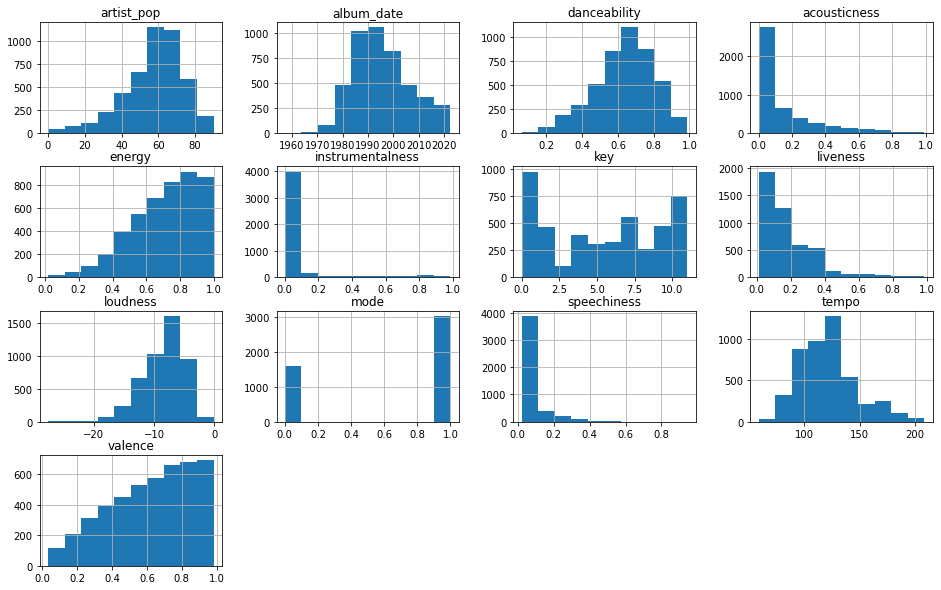

In [61]:
df.hist(figsize = (16,10))

In [ ]:
# TEST
# add a 'best fit' line
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')
ax.set_xlabel('Smarts')
ax.set_ylabel('Probability density')
ax.set_title(r'Histogram of IQ: $\mu=100$, $\sigma=15$')

#### Correlation Between Features

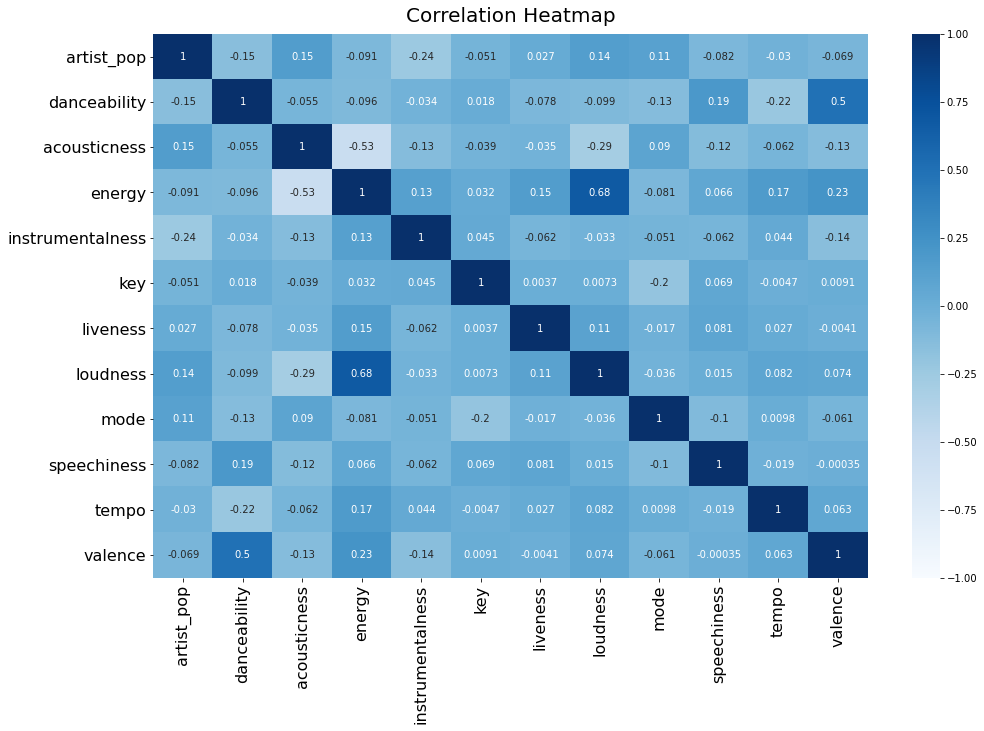

In [80]:
plt.figure(figsize = (16,10))
heatmap = sns.heatmap(df.corr(), annot=True, cmap='Blues',
           vmin=-1, vmax=1)
heatmap.set_xticklabels(heatmap.get_xmajorticklabels(),fontsize = 16)
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(),fontsize = 16)

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12);

### Clustering

#### Create clusters using KMeans

In [104]:
cluster_pipeline = Pipeline([('scaler', StandardScaler()), 
                             ('kmeans', KMeans(n_clusters=4, n_init=10,
                             verbose=2))], verbose=True)

X = df.select_dtypes(np.number)
number_cols = list(X.columns)
cluster_pipeline.fit(X)

cluster_labels = cluster_pipeline.predict(X)
df['cluster_label'] = cluster_labels


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
Initialization complete
Iteration 0, inertia 68222.65802579556
Iteration 1, inertia 47156.898747976906
Iteration 2, inertia 46300.64949039947
Iteration 3, inertia 45425.68036111507
Iteration 4, inertia 44335.65593208633
Iteration 5, inertia 43873.55235299945
Iteration 6, inertia 43379.665078226135
Iteration 7, inertia 43215.435379923576
Iteration 8, inertia 43201.46089660577
Iteration 9, inertia 43196.290073141856
Iteration 10, inertia 43192.24889975562
Iteration 11, inertia 43184.974650834214
Iteration 12, inertia 43181.48125245457
Iteration 13, inertia 43180.642163790646
Iteration 14, inertia 43180.374813764334
Converged at iteration 14: center shift 5.0425639026025454e-05 within tolerance 7.222222222222273e-05.
Initialization complete
Iteration 0, inertia 64247.92458933869
Iteration 1, inertia 46345.62298164786
Iteration 2, inertia 44786.70209271303
Iteration 3, inertia 43570.587364098516
Iteration 4, inertia 428

Create Clusters by Track using KMeans

In [105]:
# setting verbose = 2 to display and plot inertia values

X = df.select_dtypes(np.number)

scaler = StandardScaler()
scaler.fit(X)
kmeans = KMeans(n_clusters=4, verbose=2, n_init=10) #<-- init=1, verbose=2
kmeans.fit(X)
print(scaler.mean_)


cluster_label = kmeans.predict(X)
df[cluster_label] = cluster_label



Initialization complete
Iteration 0, inertia 1563478.7444260723
Iteration 1, inertia 1248031.4061076166
Iteration 2, inertia 1208548.5806279678
Iteration 3, inertia 1194800.8968064033
Iteration 4, inertia 1189005.9001612067
Iteration 5, inertia 1185702.4255633133
Iteration 6, inertia 1182899.8985240036
Iteration 7, inertia 1181964.276726099
Iteration 8, inertia 1181613.8893949392
Iteration 9, inertia 1181318.363873507
Iteration 10, inertia 1181163.9263416314
Iteration 11, inertia 1181073.332021324
Iteration 12, inertia 1181063.4071432168
Converged at iteration 12: center shift 0.0009478243583376255 within tolerance 0.005235479294603707.
Initialization complete
Iteration 0, inertia 1670692.6300852615
Iteration 1, inertia 1201019.269838104
Iteration 2, inertia 1187535.2523504402
Iteration 3, inertia 1183989.1827563383
Iteration 4, inertia 1182392.3103336089
Iteration 5, inertia 1181777.1703883505
Iteration 6, inertia 1181399.6132185005
Iteration 7, inertia 1181235.0665553038
Iteration 8,

In [106]:
df['cluster_label'].value_counts()

3    1945
2    1473
0     789
1     417
Name: cluster_label, dtype: int64

In [107]:
df

,track_uri,track_name,artist_name,artist_pop,artist_genre_1,artist_genre_2,artist_genre_3,artist_genre_4,artist_genre_5,artist_genre_6,...,mode,speechiness,tempo,valence,cluster_label,3,2,4,0,1
0,spotify:track:1qPbGZqppFwLwcBC1JQ6Vr,Wonderwall,Oasis,75,beatlesque,britpop,madchester,permanent wave,rock,,...,1,0.0366,174.584,0.456,2,3,2,4,0,1
1,spotify:track:31AOj9sFz2gM0O3hMARRBx,Losing My Religion,R.E.M.,72,alternative rock,athens indie,permanent wave,pop rock,rock,,...,0,0.0295,125.639,0.803,3,3,2,4,0,1
2,spotify:track:57iDDD9N9tTWe75x6qhStw,Bitter Sweet Symphony,The Verve,65,alternative rock,britpop,permanent wave,pop rock,rock,shoegaze,...,1,0.0479,171.176,0.518,2,3,2,4,0,1
3,spotify:track:1d6KS9GH06JAd19uiBy9IE,Ironic - 2015 Remaster,Alanis Morissette,67,canadian pop,canadian singer-songwriter,pop rock,singer-songwriter,,,...,1,0.0508,114.926,0.365,0,3,2,4,0,1
4,spotify:track:5DiXcVovI0FcY2s0icWWUu,Mr. Jones,Counting Crows,67,alternative rock,neo mellow,pop rock,rock,,,...,1,0.0363,141.621,0.726,2,3,2,4,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6389,spotify:track:5074Vt992hKDNhwXMhRceJ,Touch in the Night - Radio Version,Silent Circle,44,europop,italian disco,new italo disco,spacesynth,,,...,0,0.0328,123.088,0.924,3,3,2,4,0,1
6390,spotify:track:2AeelxeYAriGv9fHq1Fjsg,Too Many Broken Hearts,Jason Donovan,47,australian dance,australian pop,europop,new wave pop,,,...,0,0.0440,122.214,0.921,3,3,2,4,0,1
6391,spotify:track:7LvXGoyrWgYNywEC5s8awF,Ussr,Eddy Huntington,31,italian disco,new italo disco,,,,,...,0,0.0316,110.457,0.972,3,3,2,4,0,1
6392,spotify:track:2O3JCRH7IvUUbzbxEvoVAi,High Energy,Evelyn Thomas,36,disco,diva house,hi-nrg,,,,...,0,0.0619,124.252,0.711,3,3,2,4,0,1


##### Plot inertia to identify optimal number of clusters

Text(0.5, 1.0, 'Different Inertia Values for Number of Clusters 2 - 20')

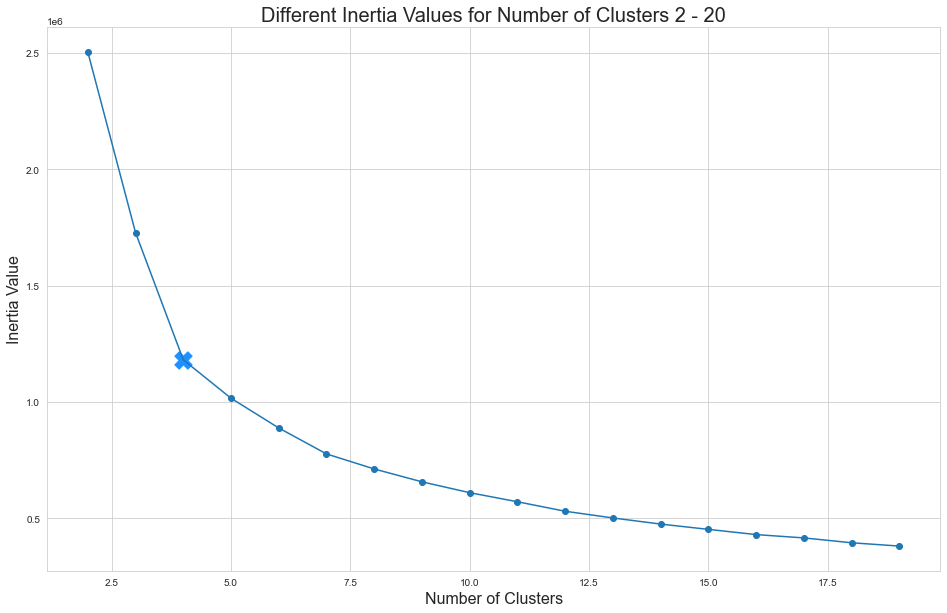

In [109]:
# Plotting Inertia

%matplotlib inline

## Reference plotting inertia article
plt.rcParams['figure.figsize'] = [16,10]
sns.set_style("whitegrid")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

inertia_list = []
for n in range(2, 20):
    kmeans_model = KMeans(n_clusters=n)
    kmeans_model.fit(X)
    inertia_list.append(kmeans_model.inertia_)
    
# plot the inertia curve
plt.plot(range(2,20),inertia_list)
plt.scatter(range(2,20),inertia_list)
plt.scatter(4, inertia_list[2], marker="X", s=300, c="dodgerblue")
plt.xlabel("Number of Clusters", size=16)
plt.ylabel("Inertia Value", size=16)
plt.title("Different Inertia Values for Number of Clusters 2 - 20", size=20)

In [96]:
number_cols

['artist_pop',
 'danceability',
 'acousticness',
 'energy',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'tempo',
 'valence']

In [134]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4624 entries, 0 to 6393
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist_pop        4624 non-null   int64  
 1   danceability      4624 non-null   float64
 2   acousticness      4624 non-null   float64
 3   energy            4624 non-null   float64
 4   instrumentalness  4624 non-null   float64
 5   key               4624 non-null   int64  
 6   liveness          4624 non-null   float64
 7   loudness          4624 non-null   float64
 8   mode              4624 non-null   int64  
 9   speechiness       4624 non-null   float64
 10  tempo             4624 non-null   float64
 11  valence           4624 non-null   float64
 12  cluster_label     4624 non-null   int32  
 13  3                 4624 non-null   int32  
 14  2                 4624 non-null   int32  
 15  4                 4624 non-null   int32  
 16  0                 4624 non-null   int32  


In [98]:
type(X['key'])

pandas.core.series.Series

##### Visualizing the clusters

In [130]:
cluster_values = df['cluster_label'].value_counts()
cluster_values
x = df['cluster_label']

In [133]:
import plotly.graph_objects as go

y = cluster_values

# Use the hovertext kw argument for hover text
fig = go.Figure(data=[go.Bar(x=x, y=y,
            hovertext=['cluster_values'])])
# Customize aspect
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='Distribution of Tracks by Cluster')
fig.show()


<AxesSubplot:>

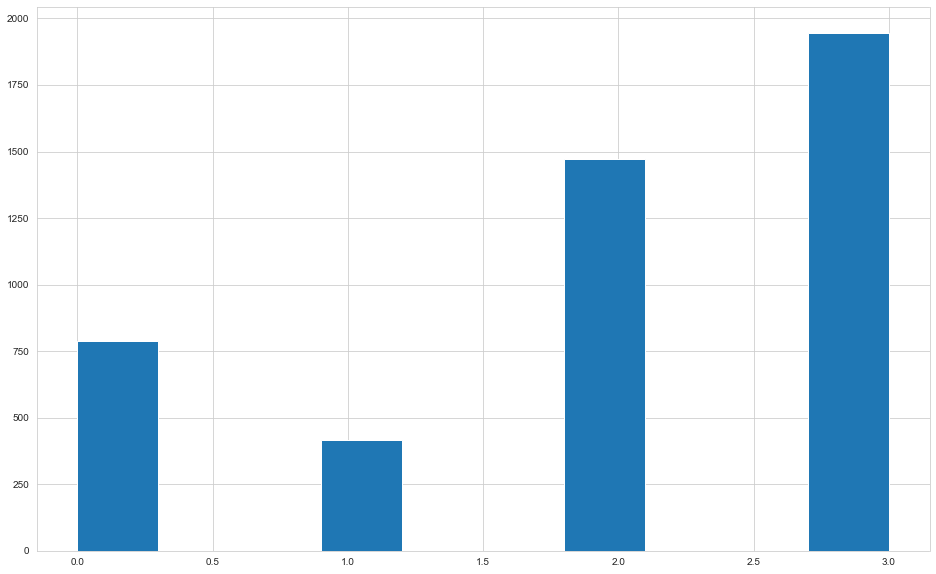

In [132]:
df['cluster_label'].hist()

In [830]:
df['cluster_label'].value_counts(normalize=True)


0    0.421576
1    0.333333
2    0.170570
3    0.074521
Name: cluster_label, dtype: float64

##### Calculate Silhouette Scores

For n_clusters = 2 The average silhouette_score is : 0.5945262595790469
For n_clusters = 3 The average silhouette_score is : 0.5936526110142946
For n_clusters = 4 The average silhouette_score is : 0.5870050262551694
For n_clusters = 5 The average silhouette_score is : 0.5732874545999443
For n_clusters = 6 The average silhouette_score is : 0.547783920545018


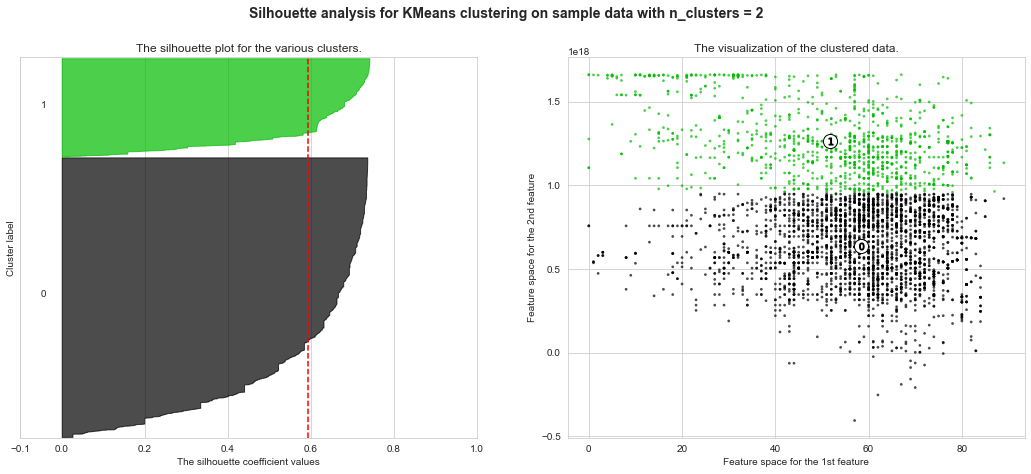

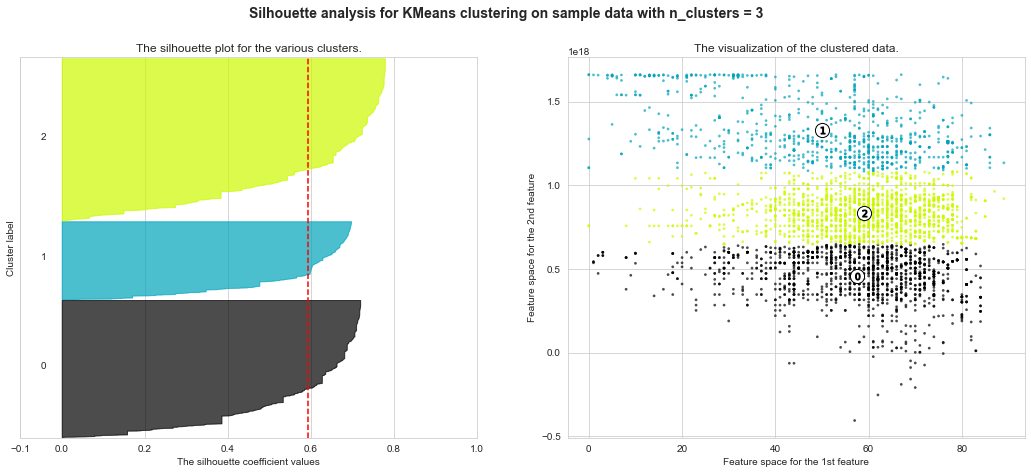

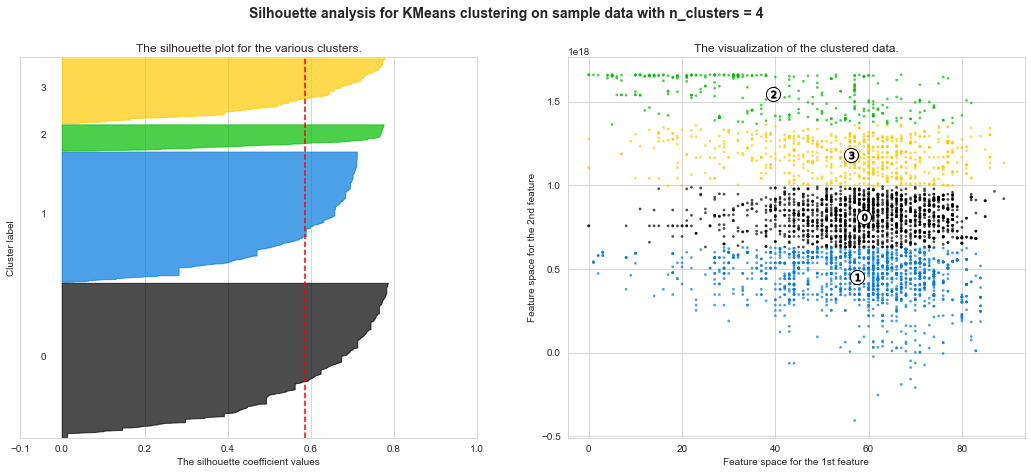

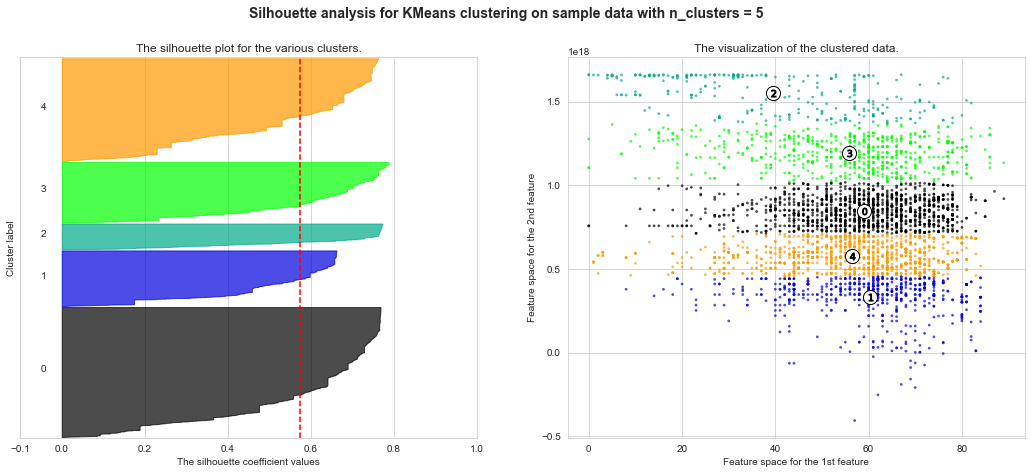

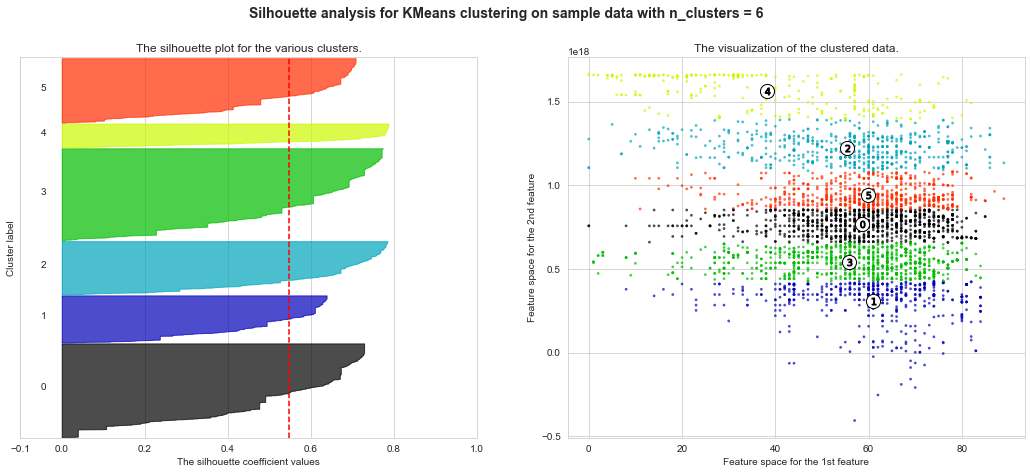

In [831]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X.iloc[:, 0], X.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

For n_clusters = 2 The average silhouette_score is : 0.38893097689581735


ValueError: x and y must be the same size

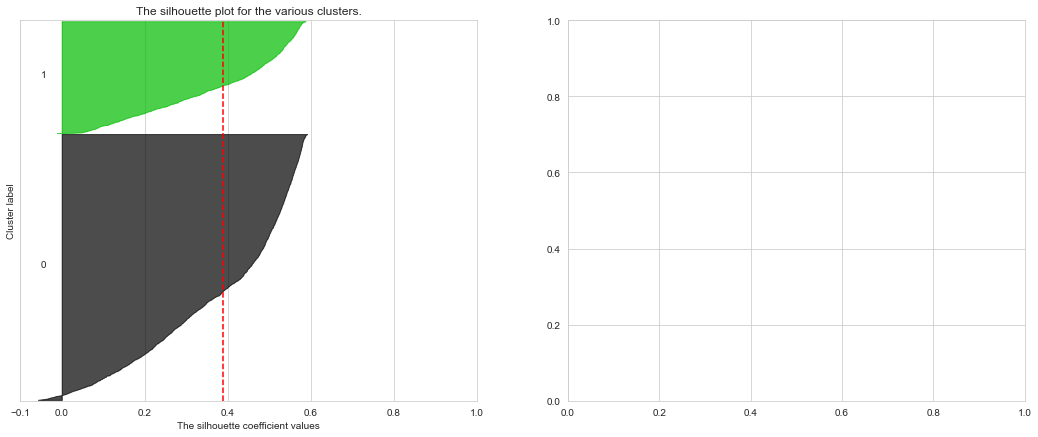

In [719]:
#Calculate Silhoutte score using Silhouette Samples

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:0], X[:1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )
    
    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

#### Create K-Prototype Clusters using K-Means and K-Mode

In order to use both categorical and continuous variables to create clusters, I am using the K-Mode clustering algorithm in addition to KMeans with K-Prototype

https://towardsdatascience.com/clustering-algorithm-for-data-with-mixed-categorical-and-numerical-features-d4e3a48066a0

***Prepare the data for K-Prototype:***

    - Scale values in dataframe
    - Convert dataframe to array
    - Make numeric variables float
    - Create a list containing the index of the categorical variables

In [758]:
#Scale values

X_num = df.select_dtypes(np.number)

scaler = StandardScaler()
scaler.fit(X_num)



StandardScaler()

In [759]:
#Concatenate scaled numeric and categorical values and convert new dataframe to array

X_num_cat = (df[['artist_genre_1', 'artist_genre_2', 'artist_genre_3', \
       'artist_genre_4', 'artist_genre_5', 'artist_genre_6']], X_num)
XKP = pd.concat(X_num_cat, axis=1)

XKP_array = XKP.values
XKP


,artist_genre_1,artist_genre_2,artist_genre_3,artist_genre_4,artist_genre_5,artist_genre_6,artist_pop,danceability,acousticness,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,cluster_label,kproto_label
0,beatlesque,britpop,madchester,permanent wave,rock,,75,0.410,0.002360,0.854,0.000000,2,0.1330,-5.609,1,0.0366,174.584,0.456,1,8
1,alternative rock,athens indie,permanent wave,pop rock,rock,,72,0.666,0.179000,0.855,0.000001,9,0.0987,-5.051,0,0.0295,125.639,0.803,0,2
2,alternative rock,britpop,permanent wave,pop rock,rock,shoegaze,65,0.356,0.033500,0.917,0.000000,9,0.4060,-6.006,1,0.0479,171.176,0.518,1,8
3,canadian pop,canadian singer-songwriter,pop rock,singer-songwriter,,,67,0.408,0.218000,0.582,0.000000,11,0.1590,-8.305,1,0.0508,114.926,0.365,2,2
4,alternative rock,neo mellow,pop rock,rock,,,67,0.578,0.183000,0.817,0.000003,0,0.2850,-6.542,1,0.0363,141.621,0.726,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5907,,,,,,,15,0.819,0.001200,0.838,0.105000,1,0.0430,-6.011,1,0.0588,122.833,0.495,0,1
5908,chicago house,classic house,deep house,hip house,vocal house,,34,0.638,0.011100,0.742,0.000095,7,0.0762,-11.421,1,0.0485,120.772,0.698,0,1
5909,classic house,,,,,,39,0.704,0.032500,0.538,0.000240,9,0.0415,-15.149,0,0.0520,119.582,0.844,0,3
5910,garage house,,,,,,5,0.742,0.057300,0.776,0.344000,1,0.2190,-7.462,0,0.0587,115.812,0.781,3,1


In [762]:
# 2:

XKP_array[:,6] = XKP_array[:,6].astype(float)
XKP_array[:,11] = XKP_array[:,11].astype(float)
XKP_array[:,14] = XKP_array[:,14].astype(float)
XKP_array[:,19] = XKP_array[:,19].astype(float)


In [763]:
XKP_array[0:20]

array([['beatlesque', 'britpop', 'madchester', 'permanent wave', 'rock',
        '', 75.0, 0.41, 0.00236, 0.854, 0.0, 2.0, 0.133, -5.609, 1.0,
        0.0366, 174.584, 0.456, 1.0, 8.0],
       ['alternative rock', 'athens indie', 'permanent wave', 'pop rock',
        'rock', '', 72.0, 0.666, 0.179, 0.855, 1.2e-06, 9.0, 0.0987,
        -5.051, 0.0, 0.0295, 125.639, 0.803, 0.0, 2.0],
       ['alternative rock', 'britpop', 'permanent wave', 'pop rock',
        'rock', 'shoegaze', 65.0, 0.356, 0.0335, 0.917, 0.0, 9.0, 0.406,
        -6.006, 1.0, 0.0479, 171.176, 0.518, 1.0, 8.0],
       ['canadian pop', 'canadian singer-songwriter', 'pop rock',
        'singer-songwriter', '', '', 67.0, 0.408, 0.218, 0.582, 0.0,
        11.0, 0.159, -8.305, 1.0, 0.0508, 114.926, 0.365, 2.0, 2.0],
       ['alternative rock', 'neo mellow', 'pop rock', 'rock', '', '',
        67.0, 0.578, 0.183, 0.817, 3.06e-06, 0.0, 0.285, -6.542, 1.0,
        0.0363, 141.621, 0.726, 1.0, 9.0],
       ['atl hip hop', 'contem

In [768]:
## 3: Note that index range for categorical values is one higher than the index value in the array
cat_index = list(range(0,6))
cat_index

[0, 1, 2, 3, 4, 5]

In [767]:
kproto = KPrototypes(n_clusters = 10, random_state = 42, n_init = 10)
kproto.fit_predict(XKP_array, categorical = cat_index)

array([6, 7, 6, ..., 5, 9, 9], dtype=uint16)

In [769]:
print(kproto.cost_)

857016.4235673009


In [770]:


#new column for cluster labels associated with each subject
df['kproto_label'] = kproto.labels_

In [771]:
df

,track_uri,track_name,artist_name,artist_pop,artist_genre_1,artist_genre_2,artist_genre_3,artist_genre_4,artist_genre_5,artist_genre_6,...,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,cluster_label,kproto_label
0,spotify:track:1qPbGZqppFwLwcBC1JQ6Vr,Wonderwall,Oasis,75,beatlesque,britpop,madchester,permanent wave,rock,,...,0.000000,2,0.1330,-5.609,1,0.0366,174.584,0.456,1,6
1,spotify:track:31AOj9sFz2gM0O3hMARRBx,Losing My Religion,R.E.M.,72,alternative rock,athens indie,permanent wave,pop rock,rock,,...,0.000001,9,0.0987,-5.051,0,0.0295,125.639,0.803,0,7
2,spotify:track:57iDDD9N9tTWe75x6qhStw,Bitter Sweet Symphony,The Verve,65,alternative rock,britpop,permanent wave,pop rock,rock,shoegaze,...,0.000000,9,0.4060,-6.006,1,0.0479,171.176,0.518,1,6
3,spotify:track:1d6KS9GH06JAd19uiBy9IE,Ironic - 2015 Remaster,Alanis Morissette,67,canadian pop,canadian singer-songwriter,pop rock,singer-songwriter,,,...,0.000000,11,0.1590,-8.305,1,0.0508,114.926,0.365,2,7
4,spotify:track:5DiXcVovI0FcY2s0icWWUu,Mr. Jones,Counting Crows,67,alternative rock,neo mellow,pop rock,rock,,,...,0.000003,0,0.2850,-6.542,1,0.0363,141.621,0.726,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5907,spotify:track:7mH6hpO4UguvZPbrZhrYwR,Work It to the Bone,LNR,15,,,,,,,...,0.105000,1,0.0430,-6.011,1,0.0588,122.833,0.495,0,9
5908,spotify:track:5eFCFpmDbqGqpdOVE9CXCh,That's the Way Love Is - Underground Mix; Edit,Ten City,34,chicago house,classic house,deep house,hip house,vocal house,,...,0.000095,7,0.0762,-11.421,1,0.0485,120.772,0.698,0,9
5909,spotify:track:5bGlU4BXhMRMMHWZnHuKhj,Someday,CeCe Rogers,39,classic house,,,,,,...,0.000240,9,0.0415,-15.149,0,0.0520,119.582,0.844,0,5
5910,spotify:track:5OiphBsPdIMIldVkx5VXJb,You’re Gonna Miss Me - 1988 Mix,Turntable Orchestra,5,garage house,,,,,,...,0.344000,1,0.2190,-7.462,0,0.0587,115.812,0.781,3,9


In [737]:
df[['kproto_label','cluster_label']].value_counts(normalize = True)

kproto_label  cluster_label
3             0                0.077596
4             0                0.067897
2             0                0.058670
              1                0.056778
9             1                0.052520
0             0                0.052283
1             0                0.050154
4             1                0.045422
5             0                0.044476
7             0                0.041401
8             1                0.040927
7             2                0.039271
5             1                0.038088
4             2                0.029572
3             1                0.026023
7             1                0.025787
2             2                0.023657
1             3                0.021528
6             1                0.018689
0             1                0.018689
9             2                0.018453
0             2                0.016560
5             3                0.014431
3             3                0.012065
            

### Feature Selection

#### Run lasso regression using different alphas and display coefficients

In [791]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4227 entries, 0 to 5911
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   track_uri         4227 non-null   object        
 1   track_name        4227 non-null   object        
 2   artist_name       4227 non-null   object        
 3   artist_pop        4227 non-null   int64         
 4   artist_genre_1    4227 non-null   object        
 5   artist_genre_2    4227 non-null   object        
 6   artist_genre_3    4227 non-null   object        
 7   artist_genre_4    4227 non-null   object        
 8   artist_genre_5    4227 non-null   object        
 9   artist_genre_6    4227 non-null   object        
 10  album             4227 non-null   object        
 11  album_date        4227 non-null   datetime64[ns]
 12  danceability      4227 non-null   float64       
 13  acousticness      4227 non-null   float64       
 14  energy            4227 n

In [811]:
df['album_date'] = df['album_date'].astype(int)




In [812]:
display(X)

,artist_pop,album_date,danceability,acousticness,energy,instrumentalness,key,liveness,loudness,mode,...,artist_genre_6_trap,artist_genre_6_tribal house,artist_genre_6_tropical,artist_genre_6_turntablism,artist_genre_6_urban contemporary,artist_genre_6_vallenato,artist_genre_6_vocal house,artist_genre_6_west coast rap,artist_genre_6_yacht rock,artist_genre_6_zolo
0,75,1995-10-02,0.410,0.002360,0.854,0.000000,2,0.1330,-5.609,1,...,0,0,0,0,0,0,0,0,0,0
1,72,1991-03-12,0.666,0.179000,0.855,0.000001,9,0.0987,-5.051,0,...,0,0,0,0,0,0,0,0,0,0
2,65,1997-09-29,0.356,0.033500,0.917,0.000000,9,0.4060,-6.006,1,...,0,0,0,0,0,0,0,0,0,0
3,67,1995-01-01,0.408,0.218000,0.582,0.000000,11,0.1590,-8.305,1,...,0,0,0,0,0,0,0,0,0,0
4,67,1993-01-01,0.578,0.183000,0.817,0.000003,0,0.2850,-6.542,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5907,15,2015-03-20,0.819,0.001200,0.838,0.105000,1,0.0430,-6.011,1,...,0,0,0,0,0,0,0,0,0,0
5908,34,1989-01-01,0.638,0.011100,0.742,0.000095,7,0.0762,-11.421,1,...,0,0,0,0,0,0,0,0,0,0
5909,39,1989-11-14,0.704,0.032500,0.538,0.000240,9,0.0415,-15.149,0,...,0,0,0,0,0,0,0,0,0,0
5910,5,2013-03-17,0.742,0.057300,0.776,0.344000,1,0.2190,-7.462,0,...,0,0,0,0,0,0,0,0,0,0


###### Before running lasso regression, making categorical variables 1, 0 using pd dummies

In [813]:
df_dummies = pd.concat(pd.get_dummies(data=df, columns=['artist_genre_1', 'artist_genre_2','artist_genre_3','artist_genre_4',\
                                'artist_genre_5','artist_genre_6']),

df_dummies.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4227 entries, 0 to 5911
Columns: 1392 entries, track_uri to artist_genre_6_zolo
dtypes: float64(9), int32(1), int64(4), object(4), uint16(1), uint8(1373)
memory usage: 6.3+ MB


In [814]:
y = df_dummies[['kproto_label']]
X = df_dummies.drop(['kproto_label','album','track_uri','track_name','artist_name'], axis=1)
X

,artist_pop,album_date,danceability,acousticness,energy,instrumentalness,key,liveness,loudness,mode,...,artist_genre_6_trap,artist_genre_6_tribal house,artist_genre_6_tropical,artist_genre_6_turntablism,artist_genre_6_urban contemporary,artist_genre_6_vallenato,artist_genre_6_vocal house,artist_genre_6_west coast rap,artist_genre_6_yacht rock,artist_genre_6_zolo
0,75,812592000000000000,0.410,0.002360,0.854,0.000000,2,0.1330,-5.609,1,...,0,0,0,0,0,0,0,0,0,0
1,72,668736000000000000,0.666,0.179000,0.855,0.000001,9,0.0987,-5.051,0,...,0,0,0,0,0,0,0,0,0,0
2,65,875491200000000000,0.356,0.033500,0.917,0.000000,9,0.4060,-6.006,1,...,0,0,0,0,0,0,0,0,0,0
3,67,788918400000000000,0.408,0.218000,0.582,0.000000,11,0.1590,-8.305,1,...,0,0,0,0,0,0,0,0,0,0
4,67,725846400000000000,0.578,0.183000,0.817,0.000003,0,0.2850,-6.542,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5907,15,1426809600000000000,0.819,0.001200,0.838,0.105000,1,0.0430,-6.011,1,...,0,0,0,0,0,0,0,0,0,0
5908,34,599616000000000000,0.638,0.011100,0.742,0.000095,7,0.0762,-11.421,1,...,0,0,0,0,0,0,0,0,0,0
5909,39,627004800000000000,0.704,0.032500,0.538,0.000240,9,0.0415,-15.149,0,...,0,0,0,0,0,0,0,0,0,0
5910,5,1363478400000000000,0.742,0.057300,0.776,0.344000,1,0.2190,-7.462,0,...,0,0,0,0,0,0,0,0,0,0


In [820]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

lr = Lasso(alpha=0.5, normalize=True)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

coef = pd.Series(lr.coef_, index = X.columns)

coef.value_counts()

-0.0    1387
dtype: int64

##### Calculate MSE and R2 using Lasso

Generating song recommendations using cdist and cosine

In [421]:
from collections import defaultdict
from scipy.spatial.distance import cdist
import difflib

number_cols = ['valence', 'acousticness', 'danceability', 'energy','instrumentalness', 
'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'artist_pop']

In [422]:
number_cols

['valence',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'tempo',
 'artist_pop']

### Calculate Distance (Cosine)

### Get Recommendations

In [419]:


def get_track_data(track, df):
    

# Gets the song data for a specific song. The song argument takes the form of a dictionary with 
# key-value pairs for the name and release year of the song.
    
    try:
        song_data = df[(df['track_name'] == track['track_name']) 
                                & (df['album_date'] == song['album_date'])].iloc[0]
        return song_data
    
    except IndexError:
        return find_song(track['track_name'], song['album_date'])
        

def get_mean_vector(song, df):
    
# gets the mean vector for a list of songs
    
    song_vectors = []
    
    for song in df:
        song_data = get_song_data(song, df)
        if song_data is None:
            print('Warning: {} does not exist in Spotify or in database'.format(track['album_name']))
            continue
        song_vector = song_data[number_cols].values()
        song_vectors.append(song_vector)  
    
    song_matrix = np.array(list(song_vectors))
    return np.mean(song_matrix, axis=0)

def flatten_dict_list(dict_list):
   
    """
    Utility function for flattening a list of dictionaries.
    """
    
    flattened_dict = defaultdict()
    for key in dict_list[0].keys():
        flattened_dict[key] = []
    
    for dictionary in dict_list:
        for key, value in dictionary.items():
            flattened_dict[key].append(value)
            
    return flattened_dict
        

def recommend_songs(song_list, df, n_songs=10):
  
    """
    Recommends songs based on a list of previous songs that a user has listened to.
    """
    
    metadata_cols = ['name', 'year', 'artists']
    song_dict = flatten_dict_list(song_list)
    
    song_center = get_mean_vector(song_list, df)
    scaler = song_cluster_pipeline.steps[0][1]
    scaled_data = scaler.transform(df[number_cols])
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data, 'cosine')
    index = list(np.argsort(distances)[:, :n_songs][0])
    
    rec_songs = spotify_data.iloc[index]
    rec_songs = rec_songs[~rec_songs['name'].isin(song_dict['name'])]
    return rec_songs[metadata_cols].to_dict(orient='records')

In [420]:
song_data

NameError: name 'song_data' is not defined

In [832]:
df

,track_uri,track_name,artist_name,artist_pop,artist_genre_1,artist_genre_2,artist_genre_3,artist_genre_4,artist_genre_5,artist_genre_6,...,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,cluster_label,kproto_label
0,spotify:track:1qPbGZqppFwLwcBC1JQ6Vr,Wonderwall,Oasis,75,beatlesque,britpop,madchester,permanent wave,rock,,...,0.000000,2,0.1330,-5.609,1,0.0366,174.584,0.456,1,6
1,spotify:track:31AOj9sFz2gM0O3hMARRBx,Losing My Religion,R.E.M.,72,alternative rock,athens indie,permanent wave,pop rock,rock,,...,0.000001,9,0.0987,-5.051,0,0.0295,125.639,0.803,0,7
2,spotify:track:57iDDD9N9tTWe75x6qhStw,Bitter Sweet Symphony,The Verve,65,alternative rock,britpop,permanent wave,pop rock,rock,shoegaze,...,0.000000,9,0.4060,-6.006,1,0.0479,171.176,0.518,1,6
3,spotify:track:1d6KS9GH06JAd19uiBy9IE,Ironic - 2015 Remaster,Alanis Morissette,67,canadian pop,canadian singer-songwriter,pop rock,singer-songwriter,,,...,0.000000,11,0.1590,-8.305,1,0.0508,114.926,0.365,2,7
4,spotify:track:5DiXcVovI0FcY2s0icWWUu,Mr. Jones,Counting Crows,67,alternative rock,neo mellow,pop rock,rock,,,...,0.000003,0,0.2850,-6.542,1,0.0363,141.621,0.726,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5907,spotify:track:7mH6hpO4UguvZPbrZhrYwR,Work It to the Bone,LNR,15,,,,,,,...,0.105000,1,0.0430,-6.011,1,0.0588,122.833,0.495,0,9
5908,spotify:track:5eFCFpmDbqGqpdOVE9CXCh,That's the Way Love Is - Underground Mix; Edit,Ten City,34,chicago house,classic house,deep house,hip house,vocal house,,...,0.000095,7,0.0762,-11.421,1,0.0485,120.772,0.698,0,9
5909,spotify:track:5bGlU4BXhMRMMHWZnHuKhj,Someday,CeCe Rogers,39,classic house,,,,,,...,0.000240,9,0.0415,-15.149,0,0.0520,119.582,0.844,0,5
5910,spotify:track:5OiphBsPdIMIldVkx5VXJb,You’re Gonna Miss Me - 1988 Mix,Turntable Orchestra,5,garage house,,,,,,...,0.344000,1,0.2190,-7.462,0,0.0587,115.812,0.781,3,9
